In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import os
import gc
print(os.listdir("../input/ieee-fraud-detection/"))
pd.options.display.max_rows = 99
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv

['train_identity.csv', 'train_transaction.csv', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv']


In [2]:
train = pd.read_pickle('../input/datas5/train.pkl')
test = pd.read_pickle('../input/datas5/test.pkl')

In [3]:
%timeit
# cardid 기준으로 최근 5일간 거래량 통계
train['uid10'] = train['uid10'].astype('str') 
train['count_last_uid10'] = train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).count())
train['mean_last_uid10'] = train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).mean())
train['min_last_uid10'] = train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).min())
train['max_last_uid10'] = train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).max())
train['std_last_uid10'] = train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).std())

test['uid10'] = test['uid10'].astype('str') 
test['count_last_uid10'] = test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).count())
test['mean_last_uid10'] = test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).mean())
test['min_last_uid10'] = test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).min())
test['max_last_uid10'] = test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).max())
test['std_last_uid10'] = test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).std())

#최근 10일 평균 대비 큰지 작은지 
train['trans_mean_last_uid10'] = train['TransactionAmt'] / train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).mean())
train['trans_std_last_uid10'] = train['TransactionAmt'] / train.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).std())
test['trans_mean_last_uid10'] = test['TransactionAmt'] / test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).mean())
test['trans_std_last_uid10'] = test['TransactionAmt'] / test.groupby('uid10')['TransactionAmt'].transform(lambda x: x.rolling(5, 1).std())





In [4]:
# 추가한것 9/15
train['uid10_id_31_cnts'] = train['uid10'].astype('str')+'_'+train['id_31'].astype('str')
test['uid10_id_31_cnts'] = test['uid10'].astype('str')+'_'+test['id_31'].astype('str')
train['uid10_id_31_cnts'] =train['uid10_id_31_cnts'].map(pd.concat([train.loc[:,['uid10_id_31_cnts']],test.loc[:,['uid10_id_31_cnts']]])['uid10_id_31_cnts'].value_counts())
test['uid10_id_31_cnts'] =test['uid10_id_31_cnts'].map(pd.concat([train.loc[:,['uid10_id_31_cnts']],test.loc[:,['uid10_id_31_cnts']]])['uid10_id_31_cnts'].value_counts())

#uid10-DeviceType
train['uid10_DeviceType_cnts'] = train['uid10'].astype('str')+'_'+train['DeviceType'].astype('str')
test['uid10_DeviceType_cnts'] = test['uid10'].astype('str')+'_'+test['DeviceType'].astype('str')
train['uid10_DeviceType_cnts'] =train['uid10_DeviceType_cnts'].map(pd.concat([train.loc[:,['uid10_DeviceType_cnts']],test.loc[:,['uid10_DeviceType_cnts']]])['uid10_DeviceType_cnts'].value_counts())
test['uid10_DeviceType_cnts'] =test['uid10_DeviceType_cnts'].map(pd.concat([train.loc[:,['uid10_DeviceType_cnts']],test.loc[:,['uid10_DeviceType_cnts']]])['uid10_DeviceType_cnts'].value_counts())

#uid10-DeviceInfo
train['uid10_DeviceInfo_cnts'] = train['uid10'].astype('str')+'_'+train['DeviceInfo'].astype('str')
test['uid10_DeviceInfo_cnts'] = test['uid10'].astype('str')+'_'+test['DeviceInfo'].astype('str')
train['uid10_DeviceInfo_cnts'] =train['uid10_DeviceInfo_cnts'].map(pd.concat([train.loc[:,['uid10_DeviceInfo_cnts']],test.loc[:,['uid10_DeviceInfo_cnts']]])['uid10_DeviceInfo_cnts'].value_counts())
test['uid10_DeviceInfo_cnts'] =test['uid10_DeviceInfo_cnts'].map(pd.concat([train.loc[:,['uid10_DeviceInfo_cnts']],test.loc[:,['uid10_DeviceInfo_cnts']]])['uid10_DeviceInfo_cnts'].value_counts())

# #u
train['uid10_P_emaildomain_cnts'] = train['uid10'].astype('str')+'_'+train['P_emaildomain'].astype('str')
test['uid10_P_emaildomain_cnts'] = test['uid10'].astype('str')+'_'+test['P_emaildomain'].astype('str')
train['uid10_P_emaildomain_cnts'] =train['uid10_P_emaildomain_cnts'].map(pd.concat([train.loc[:,['uid10_P_emaildomain_cnts']],test.loc[:,['uid10_P_emaildomain_cnts']]])['uid10_P_emaildomain_cnts'].value_counts())
test['uid10_P_emaildomain_cnts'] =test['uid10_P_emaildomain_cnts'].map(pd.concat([train.loc[:,['uid10_P_emaildomain_cnts']],test.loc[:,['uid10_P_emaildomain_cnts']]])['uid10_P_emaildomain_cnts'].value_counts())


In [5]:
train['uid4_count_full'] = train['uid4'].map(pd.concat([train['uid4'], test['uid4']], ignore_index=True).value_counts(dropna=False))
test['uid4_count_full'] = test['uid4'].map(pd.concat([train['uid4'], test['uid4']], ignore_index=True).value_counts(dropna=False))

train['uid7_count_full'] = train['uid7'].map(pd.concat([train['uid7'], test['uid7']], ignore_index=True).value_counts(dropna=False))
test['uid7_count_full'] = test['uid7'].map(pd.concat([train['uid7'], test['uid7']], ignore_index=True).value_counts(dropna=False))


In [6]:

train['uid9_count_full'] = train['uid9'].map(pd.concat([train['uid9'], test['uid9']], ignore_index=True).value_counts(dropna=False))
test['uid9_count_full'] = test['uid9'].map(pd.concat([train['uid9'], test['uid9']], ignore_index=True).value_counts(dropna=False))

train['uid10_count_full'] = train['uid10'].map(pd.concat([train['uid10'], test['uid10']], ignore_index=True).value_counts(dropna=False))
test['uid10_count_full'] = test['uid10'].map(pd.concat([train['uid10'], test['uid10']], ignore_index=True).value_counts(dropna=False))


In [7]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False)).astype('float32')
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False)).astype('float32')


train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False)).astype('float32')
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False)).astype('float32')

# train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False)).astype('float32')
# test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False)).astype('float32')

# #train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False)).astype('float32')
# #test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False)).astype('float32')

# train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False)).astype('float32')
# test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False)).astype('float32')


In [8]:
# train['uid4_ProductCD_cnts'] = train['uid4'].astype('str')+'_'+train['ProductCD'].astype('str')
# test['uid4_ProductCD_cnts'] = test['uid4'].astype('str')+'_'+test['ProductCD'].astype('str')
# train['uid4_ProductCD_cnts'] =train['uid4_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid4_ProductCD_cnts']],test.loc[:,['uid4_ProductCD_cnts']]])['uid4_ProductCD_cnts'].value_counts())
# test['uid4_ProductCD_cnts'] =test['uid4_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid4_ProductCD_cnts']],test.loc[:,['uid4_ProductCD_cnts']]])['uid4_ProductCD_cnts'].value_counts())

# train['uid7_ProductCD_cnts'] = train['uid7'].astype('str')+'_'+train['ProductCD'].astype('str')
# test['uid7_ProductCD_cnts'] = test['uid7'].astype('str')+'_'+test['ProductCD'].astype('str')
# train['uid7_ProductCD_cnts'] =train['uid7_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid7_ProductCD_cnts']],test.loc[:,['uid7_ProductCD_cnts']]])['uid7_ProductCD_cnts'].value_counts())
# test['uid7_ProductCD_cnts'] =test['uid7_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid7_ProductCD_cnts']],test.loc[:,['uid7_ProductCD_cnts']]])['uid7_ProductCD_cnts'].value_counts())


In [9]:


# train['uid9_ProductCD_cnts'] = train['uid9'].astype('str')+'_'+train['ProductCD'].astype('str')
# test['uid9_ProductCD_cnts'] = test['uid9'].astype('str')+'_'+test['ProductCD'].astype('str')
# train['uid9_ProductCD_cnts'] =train['uid9_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid9_ProductCD_cnts']],test.loc[:,['uid9_ProductCD_cnts']]])['uid9_ProductCD_cnts'].value_counts())
# test['uid9_ProductCD_cnts'] =test['uid9_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid9_ProductCD_cnts']],test.loc[:,['uid9_ProductCD_cnts']]])['uid9_ProductCD_cnts'].value_counts())

# train['uid10_ProductCD_cnts'] = train['uid10'].astype('str')+'_'+train['ProductCD'].astype('str')
# test['uid10_ProductCD_cnts'] = test['uid10'].astype('str')+'_'+test['ProductCD'].astype('str')
# train['uid10_ProductCD_cnts'] =train['uid10_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid10_ProductCD_cnts']],test.loc[:,['uid10_ProductCD_cnts']]])['uid10_ProductCD_cnts'].value_counts())
# test['uid10_ProductCD_cnts'] =test['uid10_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid10_ProductCD_cnts']],test.loc[:,['uid10_ProductCD_cnts']]])['uid10_ProductCD_cnts'].value_counts())


In [10]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in tqdm(main_columns):  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   
                
                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
            del temp_df
            gc.collect()
    return train_df, test_df

In [11]:
# ########################### D Columns
# # From columns description we know that
# # D1-D15: timedelta, such as days between previous transaction, etc.
# # 1. I can't imagine normal negative timedelta values (Let's clip Values)
# # 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# # 3. Do some aggregations based on uIDs
# # 4. Freaquency encoding
# # 5. D1,D2 are clipped by max train_df values (let's scale it)
# i_cols = ['D'+str(i) for i in range(1,16)]
# i_cols.remove('D7')
# #i_cols += ['TransactionAmt'] ## 커널이 죽는다
# # i_cols += ['isFraud']
# uids = ['uid9','uid7']  #'card1','card2','card3','card5' 추가하면 커널 죽음 #,'uid9','uid7'
# aggregations = ['mean','std']

# ####### uIDs aggregations
# train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

In [12]:

train['TransactionAmt_grouping'] = (train['TransactionAmt']/10).astype('int')
test['TransactionAmt_grouping'] = (test['TransactionAmt']/10).astype('int')

In [13]:
train['dayofyear_block'] = (train['dayofyear']/10).astype('int')
test['dayofyear_block'] = (test['dayofyear']/10).astype('int')

In [14]:
# train['day_block'] = train['day'].map(lambda x: 1 if x>27 else 0)
# test['day_block'] = test['day'].map(lambda x: 1 if x>27 else 0)

In [15]:
train['hours_block'] = (train['hours']//4).astype('int')
test['hours_block'] = (test['hours']//4).astype('int')

In [16]:
i_cols = ['TransactionAmt']
uids = ['uid1','uid9']# ['card1','uid1','uid4','uid7','uid9']  
aggregations = ['mean','std']

####### uIDs aggregations
train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

100%|██████████| 1/1 [00:13<00:00, 13.12s/it]


In [17]:
# # 추가한것 9/15
# train['uid10_TransactionAmt_grouping_cnts'] = train['uid10'].astype('str')+'_'+train['TransactionAmt_grouping'].astype('str')
# test['uid10_TransactionAmt_grouping_cnts'] = test['uid10'].astype('str')+'_'+test['TransactionAmt_grouping'].astype('str')
# train['uid10_TransactionAmt_grouping_cnts'] =train['uid10_TransactionAmt_grouping_cnts'].map(pd.concat([train.loc[:,['uid10_TransactionAmt_grouping_cnts']],test.loc[:,['uid10_TransactionAmt_grouping_cnts']]])['uid10_TransactionAmt_grouping_cnts'].value_counts()).astype('float32')
# test['uid10_TransactionAmt_grouping_cnts'] =test['uid10_TransactionAmt_grouping_cnts'].map(pd.concat([train.loc[:,['uid10_TransactionAmt_grouping_cnts']],test.loc[:,['uid10_TransactionAmt_grouping_cnts']]])['uid10_TransactionAmt_grouping_cnts'].value_counts()).astype('float32')


In [18]:
# # 추가한것 9/15
# train['uid10_dayofyear_block_cnts'] = train['uid10'].astype('str')+'_'+train['dayofyear_block'].astype('str')
# test['uid10_dayofyear_block_cnts'] = test['uid10'].astype('str')+'_'+test['dayofyear_block'].astype('str')
# train['uid10_dayofyear_block_cnts'] =train['uid10_dayofyear_block_cnts'].map(pd.concat([train.loc[:,['uid10_dayofyear_block_cnts']],test.loc[:,['uid10_dayofyear_block_cnts']]])['uid10_dayofyear_block_cnts'].value_counts()).astype('float32')
# test['uid10_dayofyear_block_cnts'] =test['uid10_dayofyear_block_cnts'].map(pd.concat([train.loc[:,['uid10_dayofyear_block_cnts']],test.loc[:,['uid10_dayofyear_block_cnts']]])['uid10_dayofyear_block_cnts'].value_counts()).astype('float32')


In [19]:
# # 추가한것 9/15
# train['uid10_hours_block_cnts'] = train['uid10'].astype('str')+'_'+train['hours_block'].astype('str')
# test['uid10_hours_block_cnts'] = test['uid10'].astype('str')+'_'+test['hours_block'].astype('str')
# train['uid10_hours_block_cnts'] =train['uid10_hours_block_cnts'].map(pd.concat([train.loc[:,['uid10_hours_block_cnts']],test.loc[:,['uid10_hours_block_cnts']]])['uid10_hours_block_cnts'].value_counts()).astype('float32')
# test['uid10_hours_block_cnts'] =test['uid10_hours_block_cnts'].map(pd.concat([train.loc[:,['uid10_hours_block_cnts']],test.loc[:,['uid10_hours_block_cnts']]])['uid10_hours_block_cnts'].value_counts()).astype('float32')


In [20]:
# categorical_features

In [21]:
train['PCA3_V75_94_1'] = train['PCA3_V75_94'].iloc[:,0]
train['PCA4_V75_94'] = train['PCA3_V75_94'].iloc[:,1]
train['PCA5_V75_94'] = train['PCA3_V75_94'].iloc[:,2]

test['PCA3_V75_94_1'] = test['PCA3_V75_94'].iloc[:,0]
test['PCA4_V75_94'] = test['PCA3_V75_94'].iloc[:,1]
test['PCA5_V75_94'] = test['PCA3_V75_94'].iloc[:,2]
train = train.drop(['PCA3_V75_94'],axis =1)
test = test.drop(['PCA3_V75_94'],axis =1)

In [22]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

In [23]:
# 바로 모델링
X_train = train.sort_values('TransactionDT').drop(['isFraud','TransactionDT','date'],axis =1)
Y_train = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT','date'],axis =1 )
train, test = [], [] 
del train, test
gc.collect()

35

In [24]:
# X_train['PCA3_V75_94']

In [25]:
numerical_columns = list(X_train.select_dtypes(include=['float16','float32','float64','int8','int16','int64']).columns)
numerical_columns=list(X_train[numerical_columns].isnull().sum()[X_train[numerical_columns].isnull().sum()>0].index)
#list(test.select_dtypes(exclude=['object']).columns)
print(X_train.shape)
X_train[numerical_columns] =X_train[numerical_columns].fillna(-999)
X_test[numerical_columns] =X_test[numerical_columns].fillna(-999)
print("filling numerical columns null values done")

(590540, 492)
filling numerical columns null values done


In [26]:
categorical_features = ['ProductCD','M4',
                        'card1','card2','card3','card4','card5','card6',
                        'addr1','addr2','dist1','dist2',
                        'P_emaildomain','R_emaildomain',
                       ]
categorical_features = list(set(categorical_features+X_train.select_dtypes(include='category').columns.tolist()+X_test.select_dtypes(include='category').columns.tolist()))
# categorical_features

In [27]:
# [col for col in X_train.columns if col not in categorical_features]

In [28]:
categorical_features +=['M1_9', 'uid1', 'uid2', 'uid3', 'uid4', 'uid6', 'uid7', 'uid8', 'uid9', 'uid10', 'V1_11', 'V35_52', 'V75_94',
                         'card1_addr1','id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
                         'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', 'id_03_04', 'id_05_06',
                     'id_07_08', 'id_35_38', 'id_17_20_ip1', 'id_21_22_ip2', 'id_24_26_ip3','TransactionAmt_grouping', 'dayofyear_block', 'hours_block',
                    ]
categorical_features = list(set(categorical_features))

In [29]:
# # Heavy dominated columns 
# total_items = len(X_train)
# keep_cols = ['isFraud']
# for col in list(X_train):
#     if X_train[col].dtype.name!='category':
#         cur_dominator = list(X_train[col].fillna(-999).value_counts())[0]
#         if (cur_dominator/total_items > 0.90) and (col not in keep_cols):
#             cur_dominator = X_train[col].fillna(-999).value_counts().index[0]
#             #print('Column:', col, ' | Dominator:', cur_dominator)
#             X_train[col] = np.where(X_train[col].fillna(-999)==cur_dominator,1,0)
#             X_test[col] = np.where(X_test[col].fillna(-999)==cur_dominator,1,0)

#             X_train[col] = X_train[col].fillna(-999).astype(int)
#             X_test[col] = X_test[col].fillna(-999).astype(int)

#             if col not in categorical_features:
#                 categorical_features.append(col)

In [30]:

for col in categorical_features :
    try :
        X_train[col] = X_train[col].cat.add_categories(-999).fillna(-999)
        X_test[col] = X_test[col].cat.add_categories(-999).fillna(-999)
    except :
        X_train[col] = X_train[col].fillna(-999)
        X_test[col] = X_test[col].fillna(-999)

In [31]:
# Categorical feature로 변경
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

In [32]:
from sklearn import preprocessing
for f in tqdm(X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist()):
#     print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X_train[f].values) + list(X_test[f].values))
    X_train[f] = lbl.transform(list(X_train[f].values))
    X_test[f] = lbl.transform(list(X_test[f].values))

100%|██████████| 87/87 [01:57<00:00,  1.04s/it]


In [33]:
from sklearn.model_selection import StratifiedKFold, KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [34]:
# column Type을 다시 지정해주자 
#https://www.kaggle.com/mhviraf/reducing-memory-size-an-alternative
# NaN 이 포함된 int value도 float으로 되어 있고, 이를 Reduce mem usuage 사용하면 데이터 손실이 발생하기도 한다.V
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    del_cols = ['TransactionAmt','dist1', 'dist2', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'D8', 'D9', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V150', 'V159', 'V164', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V332', 'V334', 'V335', 'V336']
    
    cols = [x for x in list(df.columns) if x not in del_cols]# 데이터가 변경되는 컬럼은 제외 81개
    for col in tqdm(cols):
#         if col in cols : continue 
        col_type = df[col].dtype
        #print(col_type)
#         if str(col_type)[:4]== 'date' : continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [35]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)
gc.collect()

  4%|▍         | 16/423 [00:00<00:02, 138.73it/s]

Memory usage of dataframe is 1526.23 MB


  4%|▍         | 16/423 [00:00<00:02, 158.55it/s]

Memory usage after optimization is: 878.57 MB
Decreased by 42.4%
Memory usage of dataframe is 1309.52 MB


100%|██████████| 423/423 [00:35<00:00,  3.62it/s]

Memory usage after optimization is: 766.87 MB
Decreased by 41.4%


1645

In [36]:

seeds =  79
splitcounts = 10
LGBM =  True #False #True
# 앞선 Test에서의 결과로 StratifiedKFold를 사용한다. 
# folds = TimeSeriesSplit(n_splits= splitcounts)
folds = KFold(n_splits=splitcounts, random_state = seeds) 
# folds = StratifiedKFold(n_splits=splitcounts, random_state = seeds)

# params =  {
#         'objective': 'binary',
#         'metric': 'auc',
#         'num_threads': 4,
#         'learning_rate': 0.01, 
#         'num_iterations' : 10000,
#         'max_depth': -1,
#         'reg_alpha': 0.3,
#          'reg_lambda': 0.3,
#         'bagging_seed' : seeds,
#         'verbose' : -1,
#         'seed' :seeds
#     }

if LGBM :


    params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 
              'num_leaves': 650, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 
              'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582,
              'min_child_weight': 0.03208937707510653, 'bagging_seed': seeds, 'verbose': -1, 'seed': seeds}
    CVscore = []
    predicts = []
    X_idx = []
    X_predicts = []
    importance = pd.DataFrame(np.zeros((X_train.shape[1], splitcounts)), columns=['Fold_{}'.format(i) for i in range(1, splitcounts+1)], index=X_train.columns)
    for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
        X_train_, X_val_ = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        Y_train_, Y_val_ = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

        lgb_train = lgb.Dataset(data=X_train_,label = Y_train_)
        lgb_valid = lgb.Dataset(data=X_val_,label = Y_val_)

        lgb_model = lgb.train(params, lgb_train, valid_sets =lgb_valid, verbose_eval = 200, early_stopping_rounds= 300)

        y = lgb_model.predict(X_val_, num_iteration = lgb_model.best_iteration)
        X_predicts.append(y)
        X_idx += list(train_idx)
        score = roc_auc_score(Y_val_,y)
        CVscore.append(score)
        print("Fold : ", fold_, "val_auc : ", score )
        y = lgb_model.predict(X_test,num_iteration = lgb_model.best_iteration)
        importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
        predicts.append(y)
        lgb_model, lgb_train, lgb_valid = None, None, None
        del lgb_model,lgb_train, lgb_valid
        gc.collect()

    print("CV Score : " ,np.mean(CVscore))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(predicts, axis =0)
    submission.to_csv('submission.csv')
    importance.to_csv('importance.csv')
    # pd.DataFrame({'TransactionID':X_idx,'predict':X_predicts}).to_csv('modelprediction.csv')

else :
    params = {
                'n_estimators': 5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':seeds,
                'metric_period':500,
                'od_wait':500, #earlystoping
                'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 
    
    CVscore = []
    predicts = []
    X_idx = []
    X_predicts = []
    importance = pd.DataFrame(np.zeros((X_train.shape[1], splitcounts)), columns=['Fold_{}'.format(i) for i in range(1, splitcounts+1)], index=X_train.columns)
#     for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
#         X_train_+fold_, Y_train_+fold_ =X_train.iloc[train_idx,:],Y_train.iloc[train_idx]
        
    for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
        print(fold_)
#         X_train_, X_val_ = , 
#         Y_train_, Y_val_ = , 

        cat_model = CatBoostClassifier(**params)        
        cat_model.fit(
            X_train.iloc[train_idx,:],Y_train.iloc[train_idx],
            eval_set=(X_train.iloc[test_idx,:], Y_train.iloc[test_idx]),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True)


        y = cat_model.predict_proba(X_val_)[:,1]
        X_predicts.append(y)
#         X_idx += list(train_idx)
        score = roc_auc_score(Y_val_,y)
        CVscore.append(score)
        print("Fold : ", fold_, "val_auc : ", score )
        y = cat_model.predict_proba(X_val_)[:,1]
#         importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
        predicts.append(y)
        cat_model = None
        del cat_model, X_train_, X_val_,Y_train_, Y_val_
        gc.collect()

    print("CV Score : " ,np.mean(CVscore))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(predicts, axis =0)
    submission.to_csv('submission.csv')
#     importance.to_csv('importance.csv')

Training until validation scores don't improve for 300 rounds.
[200]	valid_0's auc: 0.908285
[400]	valid_0's auc: 0.920521
[600]	valid_0's auc: 0.926252
[800]	valid_0's auc: 0.928505
[1000]	valid_0's auc: 0.929816
[1200]	valid_0's auc: 0.930401
[1400]	valid_0's auc: 0.930641
[1600]	valid_0's auc: 0.930681
[1800]	valid_0's auc: 0.930617
Early stopping, best iteration is:
[1556]	valid_0's auc: 0.930808
Fold :  0 val_auc :  0.9308083643542682
Training until validation scores don't improve for 300 rounds.
[200]	valid_0's auc: 0.913737
[400]	valid_0's auc: 0.926246
[600]	valid_0's auc: 0.932753
[800]	valid_0's auc: 0.93639
[1000]	valid_0's auc: 0.9384
[1200]	valid_0's auc: 0.939106
[1400]	valid_0's auc: 0.93962
[1600]	valid_0's auc: 0.940021
[1800]	valid_0's auc: 0.940222
[2000]	valid_0's auc: 0.940461
[2200]	valid_0's auc: 0.940549
[2400]	valid_0's auc: 0.940544
Early stopping, best iteration is:
[2288]	valid_0's auc: 0.940615
Fold :  1 val_auc :  0.9406145990024372
Training until validati

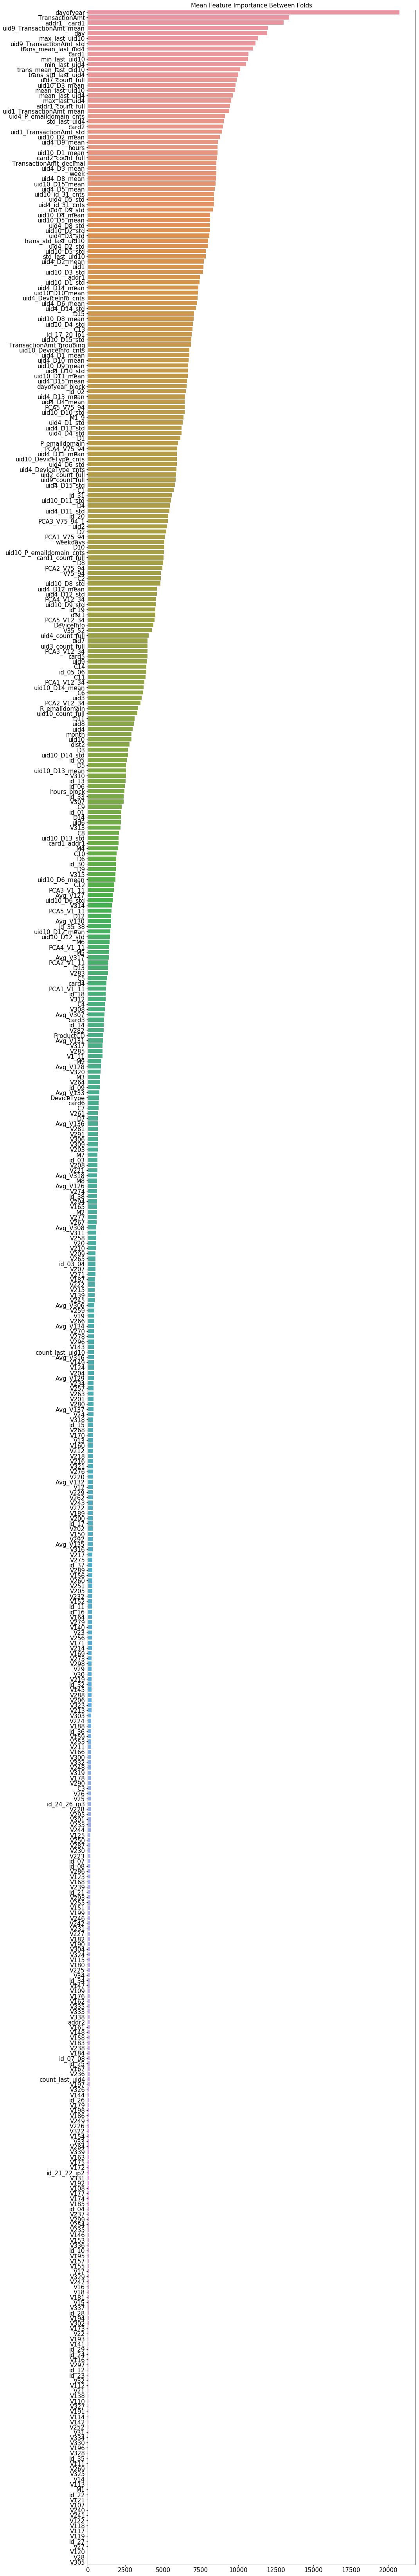

In [37]:
if LGBM :

    importance['Mean_Importance'] = importance.sum(axis=1) / splitcounts
    importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

    plt.figure(figsize=(15, 120))
    sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

    plt.xlabel('')
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Mean Feature Importance Between Folds', size=15)

    plt.show()